# submitted by Tarang Ranpara (202011057)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! rm -rf pd_index 
! rm -rf pd2_index 
! rm -rf pd3_index 
! rm -rf data

In [1]:
!pip install python-terrier

In [2]:
import pyterrier as pt
if not pt.started():
    pt.init()

PyTerrier 0.6.0 has loaded Terrier 5.5 (built by craigmacdonald on 2021-05-20 13:12)


In [3]:
import os
import re
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.corpus import brown
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import pickle
import gensim
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
import matplotlib.pyplot as plt

# downloading essentials
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [4]:
class StemmerCorpus:
    def __init__(self, word_lst):
        self.word_lst = word_lst
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.processed_words = []

    def process(self):
        for word in tqdm(self.word_lst):
            word = word.lower()
            if (word.isalpha()) and (word not in self.stop_words):
                self.processed_words.append(word)

        self.processed_words = list(set(self.processed_words))

    def get_processed_words(self):
        if self.processed_words == []:
            self.process()

        return self.processed_words

In [5]:
class DistanceMeasures:
    def __init__(self):
        self.inf = 9999

    def pi(self, s1, s2):
        l1 = len(s1)
        l2 = len(s2)

        min_ind = min(l1, l2)

        answer = []
        index = None
        for i in range(max(l1, l2)):
            if i < min_ind and s1[i] == s2[i]:
                answer.append(0)
            else:
                if index == None:
                    index = i
                answer.append(1)
        if sum(answer) == 0:
            index = 0

        return answer, l1, l2, index, len(answer)
    
    def d1(self, s1, s2):
        answer, l1, l2, m, n = self.pi(s1, s2)
        if m == None:
            return self.inf
        else:
            distance = 0
            for i in range(m, n):
                distance += (1/2**i) * answer[i]

            return distance

    def d2(self, s1, s2):
        answer, l1, l2, m, n = self.pi(s1, s2)
        if m == None or m==0 or sum(answer) == 0:
            return self.inf
        else:
            return (1/m) * (1 - (0.5)**(n-m))/(0.5)

    def d3(self, s1, s2):
        answer, l1, l2, m, n = self.pi(s1, s2)
        if m == None or m==0 or sum(answer) == 0:
            return self.inf
        else:
            return (n-m)/(m) * (1 - (0.5)**(n-m))/(0.5)

    def d4(self, s1, s2):
        answer, l1, l2, m, n = self.pi(s1, s2)
        if m == None:
            return self.inf
        else:
            if sum(answer) == 0:
                return 0
            return (n-m)/(n) * (1 - (0.5)**(n-m))/(0.5)

    def memoize(func):
        mem = {}
        def memoizer(*args, **kwargs):
            key = str(args) + str(kwargs)
            if key not in mem:
                mem[key] = func(*args, **kwargs)
            return mem[key]
        return memoizer


    @memoize    
    def levenshtein(self, s, t):
        if s == "":
            return len(t)
        if t == "":
            return len(s)
        if s[-1] == t[-1]:
            cost = 0
        else:
            cost = 1

        res = min([self.levenshtein(s[:-1], t)+1,
                  self.levenshtein(s, t[:-1])+1, 
                  self.levenshtein(s[:-1], t[:-1]) + cost])

        return res

In [7]:
root_dir =  './drive/MyDrive/NLP/A2'

def get_np_arr_path(root_dir, distance_measure):
        return root_dir + f'/{distance_measure}.npy'

def get_clusters_path(root_dir, distance_measure):
        return root_dir + f'/{distance_measure}'

In [9]:
def gen_clusters(threshold, mat, dm):
    dir = get_clusters_path(root_dir, dm)
    print(f'dumping clusters in: {dir}')

    for th in tqdm(threshold):
      clustering = AgglomerativeClustering(affinity = 'precomputed', linkage='single', distance_threshold = th, compute_full_tree = True, n_clusters = None)
      cl_obj = clustering.fit(mat)
      path = f'{dir}/{int(th*100)}'
      with open(path, 'wb') as file:
          pickle.dump(cl_obj, file)

In [10]:
def plot_clusters(dm):
    dir_path = get_clusters_path(root_dir, dm)
    d_files = os.listdir(dir_path)

    labels = []
    th = []
    for fil in d_files:
        th.append(int(fil) / 100)
        obj = pickle.load(open(os.path.join(dir_path, fil), 'rb'))
        labels.append(np.max(obj.labels_)+1)

    plt.plot(th, labels)
    plt.show()

In [11]:
class YASS_Stemmer:
    def __init__(self, data, dm, threshold):
        # YASS stemmer by d4 and threshold = 3
        self.d_obj = pickle.load(open(os.path.join(get_clusters_path(root_dir, dm), str(threshold)),'rb'))

        self.clusters = self.d_obj.labels_
        self.cluster_word_dict = dict()
        for i in range(len(self.clusters)):
            cluster_no = self.clusters[i]

            if cluster_no in self.cluster_word_dict:
                self.cluster_word_dict[cluster_no].append(data[i])
            else:
                self.cluster_word_dict[cluster_no] = [data[i]]

        self.cluster_root_dict = dict()
        for key, val in self.cluster_word_dict.items():
            self.cluster_root_dict[key] = min(val, key = len)

    def stem(self, word):
        for key, value in self.cluster_word_dict.items():
            if word in value:
                return self.cluster_root_dict[key]

        return word

In [12]:
class PreProcessString:
    def __init__(self, 
                 lower=True, 
                 remove_nums_special_chars=True, 
                 stemmer = PorterStemmer(), 
                 remove_stop_words=True):

        self.text = None
        self.lower = lower
        self.stemmer = stemmer
        self.remove_nums_special_chars = remove_nums_special_chars
        self.remove_stop_words = remove_stop_words

    def setText(self, text):
        self.text = text

    def preProcess(self):
        temp_text_data = self.text 

        if self.text == None:
            raise Exception("text can not be None")

        if self.lower:
            temp_text_data = temp_text_data.lower()
        
        if self.remove_nums_special_chars:
            temp_text_data = re.sub(r'[^\w\s]', '', temp_text_data)
            temp_text_data = re.sub(r'\d+', '', temp_text_data)

        tokens = nltk.word_tokenize(temp_text_data)

        if self.remove_stop_words:
            stopwords = set(nltk.corpus.stopwords.words('english'))
            tokens = [token for token in tokens if token not in stopwords]

        tokens = list(map(self.stemmer.stem,tokens))

        if len(tokens) > 0:
            return ' '.join(tokens)
        else:
            return ''

In [13]:
class CorporaReader:
    def __init__(self, rootDir, stemmer = PorterStemmer()):
        self.rootDir = rootDir
        self.preProcessor = PreProcessString(stemmer=stemmer)
        self.files, self.fileNames = self.listFiles()

    # returns file names with full path and list of file names 
    def listFiles(self):
        print('Indexing all the data files')
        listOfFiles = []
        listOfFileNames = []
        topDirs = os.listdir(self.rootDir)
        for topDir in topDirs:
            topDir = os.path.join(self.rootDir, topDir)
            internalDirs = os.listdir(topDir)
            for internalDir in internalDirs:
                internalDir = os.path.join(topDir, internalDir)
                for fileName in os.listdir(internalDir):
                    listOfFiles.append(os.path.join(internalDir, fileName))
                    listOfFileNames.append(fileName)

        return listOfFiles, listOfFileNames

    # returns data in the pyterrier format
    def read(self):
        fileNames, fileContents = [], []
        numFiles = len(self.files)
        for i in tqdm(range(numFiles)):
            fileName = self.files[i]
            with open(fileName,'r') as fobj:
                content = fobj.read()

            soup = bs(content, "lxml")
            temp_text_data = soup.find('text').text

            self.preProcessor.setText(temp_text_data)
            text = self.preProcessor.preProcess()

            if text != '':
                fileNames.append(self.fileNames[i])
                fileContents.append(text)

        return pd.DataFrame({'docno': fileNames, 'text': fileContents})

In [14]:
class QrelsReader:
    def __init__(self, filePath):
        self.filePath = filePath

    # returns qrels in the pyterrier format
    def read(self):
        return pt.io.read_qrels(self.filePath)

In [15]:
class QueryReader:
    def __init__(self, file_path, stemmer = PorterStemmer()):
        self.file_path = file_path
        self.preProcessor = PreProcessString(stemmer=stemmer)

    # returns queries in the pyterrier format
    def read(self):
        with open(self.file_path,'r') as f:
            content = f.read()

        soup = bs(content, "lxml")
        qNum = [int(num.text) for num in soup.find_all('num')]
        queries = [desc.text for desc in soup.find_all('desc')]

        for i in tqdm(range(len(queries))):
            self.preProcessor.setText(queries[i])
            queries[i] = self.preProcessor.preProcess()
        
        return pd.DataFrame({'qid':qNum, 'query':queries})

In [16]:
class IndexUtil:
    def __init__(self, 
                 pt,
                 index_loc):
        self.pt = pt 
        self.index_loc = index_loc 
        self.index_ref = None

    # builds the index from given index columns and meta columns 
    def buildIndex(self, data, index_column, meta_columns):
        pd_indexer = pt.DFIndexer(self.index_loc)
        meta_data = dict()
        for meta_column in meta_columns:
            meta_data[meta_column] = data[meta_column]

        
        self.index_ref = pd_indexer.index(data[index_column], **meta_data)

    # returns the evaluation metrics as per given queries & qrels 
    def evaluate(self, wv_models, topics, qrels, metrics):
        batchRetrieval = [self.pt.BatchRetrieve(self.index_ref, wmodel=wv_model) for wv_model in wv_models]
        return self.pt.Experiment(
          batchRetrieval,
          topics,
          qrels,
          metrics
        )

## Driver code

In [11]:
! mkdir data
! cp 'drive/MyDrive/IRLAB/A3/FIRE_Dataset_EN_2010.rar' './data/FIRE_Dataset_EN_2010.rar' >/dev/null
! unrar x data/FIRE_Dataset_EN_2010.rar data >/dev/null
! tar -xvf  './data/FIRE_Dataset_EN_2010/English-Data.tgz' -C './data/FIRE_Dataset_EN_2010/' >/dev/null
! gzip -d ./data/FIRE_Dataset_EN_2010/en.qrels.76-125.2010.txt.gz >/dev/null

In [17]:
# defining dataset global vars
DATASET_TOPICS = './data/FIRE_Dataset_EN_2010/en.topics.76-125.2010.txt'
DATASET_QRELS = './data/FIRE_Dataset_EN_2010/en.qrels.76-125.2010.txt'
DATASET_ROOT  = './data/FIRE_Dataset_EN_2010/TELEGRAPH_UTF8/'

In [6]:
dm = DistanceMeasures()

# cross verification of values from paper
print(f"D1: {dm.d1('astronomer', 'astronomically')}")
print(f"D2: {dm.d2('astronomer', 'astronomically')}")
print(f"D3: {dm.d3('astronomer', 'astronomically')}")
print(f"D4: {dm.d4('astronomer', 'astronomically')}")
print(f"levenshtein: {dm.levenshtein('astronomer', 'astronomically')}")

D1: 0.0076904296875
D2: 0.24609375
D3: 1.4765625
D4: 0.84375
levenshtein: 6


In [8]:
stemmer_corpus = brown.words(categories='news')
sc = StemmerCorpus(stemmer_corpus) 
data = sc.get_processed_words()

100%|██████████| 100554/100554 [00:00<00:00, 274378.67it/s]


### Generating Distance Matrices

In [1]:
d1_p = np.zeros((len(data), len(data)))
 
for i in range(len(data)):
    for j in range(i+1, len(data)):
        temp = dm.d1(data[i], data[j])
        d1_p[i,j], d1_p[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'd1'), 'wb') as f:
    np.save(f, d1_p)

In [ ]:
d2_p = np.zeros((len(data), len(data)))
 
for i in range(len(data)):
    for j in range(i+1, len(data)):
        temp = dm.d2(data[i], data[j])
        d2_p[i,j], d2_p[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'd2'), 'wb') as f:
    np.save(f, d2_p)

In [ ]:
d3_p = np.zeros((len(data), len(data)))
 
for i in range(len(data)):
    for j in range(i+1, len(data)):
        temp = dm.d3(data[i], data[j])
        d3_p[i,j], d3_p[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'd3'), 'wb') as f:
    np.save(f, d3_p)

In [ ]:
d4_p = np.zeros((len(data), len(data)))
 
for i in range(len(data)):
    for j in range(i+1, len(data)):
        temp = dm.d4(data[i], data[j])
        d4_p[i,j], d4_p[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'd4'), 'wb') as f:
    np.save(f, d4_p)

In [10]:
levenshtein_p = np.zeros((len(data), len(data)))
 
for i in range(len(data)):
    for j in range(i+1, len(data)):
        temp = dm.d4(data[i], data[j])
        levenshtein_p[i,j], levenshtein_p[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'levenshtein'), 'wb') as f:
    np.save(f, levenshtein_p)

### Calculating clusters 

In [ ]:
t1 = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
gen_clusters(t1, d1_p, 'd1')

dumping clusters in: ./drive/MyDrive/NLP/A2/d1


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


In [ ]:
t2 = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
gen_clusters(t2, d2_p, 'd2')

dumping clusters in: ./drive/MyDrive/NLP/A2/d2


100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


In [ ]:
t3 = [0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3]
d3_p = np.load(get_np_arr_path(root_dir, 'd3'), mmap_mode = 'r')
gen_clusters(t3, d3_p, 'd3')

dumping clusters in: ./drive/MyDrive/NLP/A2/d3


100%|██████████| 12/12 [00:34<00:00,  2.87s/it]


In [ ]:
t4 = [0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
d4_p = np.load(get_np_arr_path(root_dir, 'd4'), mmap_mode = 'r')
gen_clusters(t4, d4_p, 'd4')

dumping clusters in: ./drive/MyDrive/NLP/A2/d4


100%|██████████| 18/18 [00:46<00:00,  2.56s/it]


In [14]:
l = [0.15, 0.2, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
gen_clusters(l, levenshtein_p, 'levenshtein')

dumping clusters in: ./drive/MyDrive/NLP/A2/levenshtein


100%|██████████| 18/18 [00:52<00:00,  2.90s/it]


### plotting number of clusters vs threshold

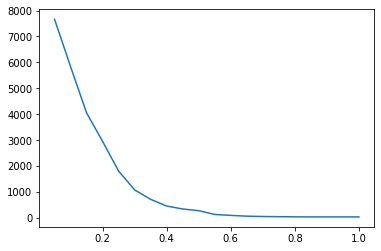

In [ ]:
plot_clusters('d1')

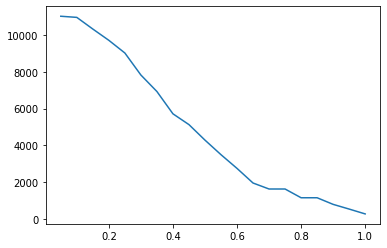

In [ ]:
plot_clusters('d2')

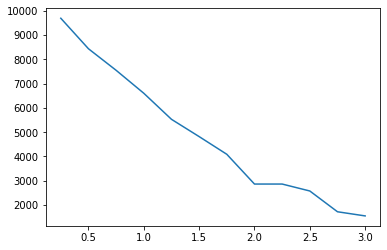

In [ ]:
plot_clusters('d3')

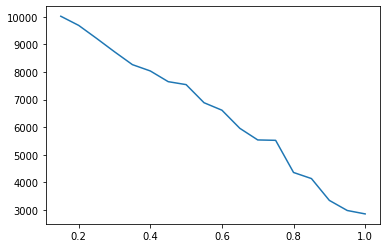

In [ ]:
plot_clusters('d4')

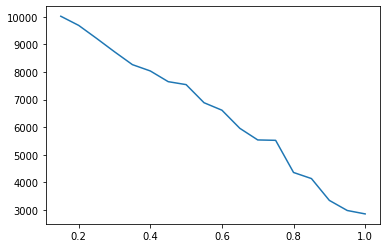

In [16]:
plot_clusters('levenshtein')

### Porter Stemmer 

In [ ]:
cr = CorporaReader(DATASET_ROOT)
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [15:06<00:00, 138.51it/s]


,docno,text
0,1060823_frontpage_story_6645719.utf8,telegraph calcutta frontpag want cream cure te...
1,1060619_frontpage_story_6371858.utf8,telegraph calcutta frontpag indian busi invas ...
2,1060129_frontpage_story_5777824.utf8,telegraph calcutta frontpag bryan adam u time ...
3,1061130_frontpage_index.utf8,telegraph calcutta frontpag shibu soren case m...
4,1061119_frontpage_story_7022387.utf8,telegraph calcutta frontpag student dead assam...


In [ ]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [ ]:
q = QueryReader(DATASET_TOPICS)
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 1871.27it/s]


,qid,query
0,76,reason behind protest meena leader inclus gurj...
1,77,attack hezbollah guerrilla indian isra forc
2,78,conflict ashok singhal presid vishwa hindu par...
3,79,plan build road china mount everest
4,80,initi legal proceed advani involv demolit babr...


In [ ]:
index = IndexUtil(pt, "./pd_index")

In [ ]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [ ]:
print('Porter Stemmer results: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

Porter Stemmer results: 


,name,map
0,BR(TF_IDF),0.441776


### YASS - d1 distance Measure

In [ ]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(data, 'd1', 55))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [1:24:10<00:00, 24.87it/s]


,docno,text
0,1060823_frontpage_story_6645719.utf8,telegraph calcutta frontpage f de cure nw rabi...
1,1060619_frontpage_story_6371858.utf8,telegraph calcutta frontpage sw r sw bay l ku ...
2,1060129_frontpage_story_5777824.utf8,telegraph calcutta frontpage oil nw u r l gigg...
3,1061130_frontpage_index.utf8,telegraph calcutta frontpage shibu soren sw sw...
4,1061119_frontpage_story_7022387.utf8,telegraph calcutta frontpage met cd assam sw r...


In [ ]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [ ]:
q = QueryReader(DATASET_TOPICS)
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 1779.52it/s]


,qid,query
0,76,reason behind protest meena leader inclus gurj...
1,77,attack hezbollah guerrilla indian isra forc
2,78,conflict ashok singhal presid vishwa hindu par...
3,79,plan build road china mount everest
4,80,initi legal proceed advani involv demolit babr...


In [ ]:
index = IndexUtil(pt, "./pd2_index")

In [ ]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [ ]:
print('yass - d1 distance: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

yass - d1 distance: 


,name,map
0,BR(TF_IDF),0.326328


### YASS - d2 distance Measure

In [ ]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(data, 'd2', 100))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [1:28:13<00:00, 23.73it/s]


,docno,text
0,1060823_frontpage_story_6645719.utf8,telegraph calcutta frontpage dud pal cure mac ...
1,1060619_frontpage_story_6371858.utf8,telegraph calcutta frontpage bow ye may bay l ...
2,1060129_frontpage_story_5777824.utf8,telegraph calcutta frontpage oil nw u nut go g...
3,1061130_frontpage_index.utf8,telegraph calcutta frontpage shibu soren bow m...
4,1061119_frontpage_story_7022387.utf8,telegraph calcutta frontpage buy cd assam may ...


In [ ]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [ ]:
q = QueryReader(DATASET_TOPICS, stemmer=YASS_Stemmer(data, 'd2', 100))
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 464.75it/s]


,qid,query
0,76,oil da rex meena ah inclusion gurjars ed dud
1,77,icy hezbollah guerrillas bow israeli ye
2,78,roof ashok singhal lou vishwa hindu parishad l...
3,79,tv fil cry en mount everest
4,80,initiation cry ap advani involvement demolitio...


In [ ]:
index = IndexUtil(pt, "./pd3_index")

In [ ]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [ ]:
print('yass - d2 distance: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

yass - d2 distance: 


,name,map
0,BR(TF_IDF),0.356716


### YASS - d3 distance Measure

In [ ]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(data, 'd3', 300))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [2:11:16<00:00, 15.94it/s]


,docno,text
0,1070213_bengal_story_7386574.utf8,telegraph calcutta bengal mamata sit spy land ...
1,1070809_bengal_index.utf8,telegraph calcutta bengal sells fill sky gals ...
2,1070617_bengal_index.utf8,telegraph calcutta bengal vow r nandigram hoyt...
3,1070927_bengal_story_8366827.utf8,telegraph calcutta bengal hot calcutta sept gr...
4,1070317_bengal_story_7529474.utf8,telegraph calcutta bengal bandh guiding nap se...


In [ ]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [ ]:
q = QueryReader(DATASET_TOPICS, stemmer=YASS_Stemmer(data, 'd3', 300))
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 281.66it/s]


,qid,query
0,76,key spy protests meena leaders inclusion gurja...
1,77,van hezbollah guerrillas w israeli ties
2,78,hunt ashok singhal catchers vishwa hindu paris...
3,79,cooke low sad china sky everest
4,80,initiation deaf nab advani involvement demolit...


In [ ]:
index = IndexUtil(pt, "./pd4_index")

In [ ]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [ ]:
print('yass - d3 distance: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

yass - d3 distance: 


,name,map
0,BR(TF_IDF),0.382259


### YASS - d4 distance Measure

In [26]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(data, 'd4', 100))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [2:41:12<00:00, 12.98it/s]


,docno,text
0,1070213_bengal_story_7386574.utf8,telegraph calcutta bengal mamata ad woodland l...
1,1070809_bengal_index.utf8,telegraph calcutta bengal thursday coles hospi...
2,1070617_bengal_index.utf8,telegraph calcutta bengal voter june nandigram...
3,1070927_bengal_story_8366827.utf8,telegraph calcutta bengal un calcutta sept cup...
4,1070317_bengal_story_7529474.utf8,telegraph calcutta bengal bandh try march se m...


In [27]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [28]:
q = QueryReader(DATASET_TOPICS, stemmer=YASS_Stemmer(data, 'd4', 100))
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 215.59it/s]


,qid,query
0,76,thus behind lost meena leaders inclusion gurja...
1,77,attacks hezbollah guerrillas cup israeli chat
2,78,due ashok singhal awe vishwa hindu parishad lk...
3,79,nae b ffa give b everest
4,80,initiation legal impact advani involvement dem...


In [ ]:
! rm -rf pd4_index

In [29]:
index = IndexUtil(pt, "./pd5_index")

In [30]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [31]:
print('yass - d4 distance: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

yass - d4 distance: 


,name,map
0,BR(TF_IDF),0.393111


### YASS - levenshtein distance Measure

In [18]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(data, 'levenshtein', 100))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [2:33:21<00:00, 13.65it/s]


,docno,text
0,1061219_frontpage_index.utf8,telegraph calcutta frontpage son senior ips lo...
1,1060711_frontpage_index.utf8,telegraph calcutta frontpage
2,1060321_frontpage_story_5993623.utf8,telegraph calcutta frontpage twin bs rush spec...
3,1060411_frontpage_story_6084638.utf8,telegraph calcutta frontpage subhas slip red a...
4,1061209_frontpage_story_7117673.utf8,telegraph calcutta frontpage end turn ice age ...


In [24]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [25]:
q = QueryReader(DATASET_TOPICS, stemmer=YASS_Stemmer(data, 'levenshtein', 100))
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 251.72it/s]


,qid,query
0,76,mar r sow meena lie inclusion gurjars schedule...
1,77,kkk hezbollah guerrillas indian israeli ton
2,78,ad ashok singhal du vishwa hindu parishad lk a...
3,79,jones build pi china tax everest
4,80,initiation run janet advani involvement demoli...


In [26]:
index = IndexUtil(pt, "./pd6_index")

In [29]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [23]:
print('yass - levenshtein distance: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

yass - levenshtein distance: 


,name,map
0,BR(TF_IDF),0.402057


## Word2vec Clustering

In [19]:
path = api.load("word2vec-google-news-300", return_path=True)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [20]:
model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)

In [47]:
wv_vocab = []
for word in data:
    try:
        model.wv[word]
        wv_vocab.append(word)
    except:
        continue

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [49]:
wvm = np.zeros((len(wv_vocab), len(wv_vocab)))
 
for i in range(len(wv_vocab)):
    for j in range(i+1, len(wv_vocab)):
        temp = 1 - model.similarity(wv_vocab[i], wv_vocab[j])
        wvm[i,j], wvm[j, i] = temp, temp

with open(get_np_arr_path(root_dir, 'wv'), 'wb') as f:
    np.save(f, wvm)

In [50]:
t = [0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
gen_clusters(t, wvm, 'wv')

dumping clusters in: ./drive/MyDrive/NLP/A2/wv


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


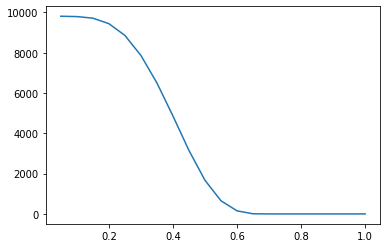

In [51]:
plot_clusters('wv')

In [52]:
cr = CorporaReader(DATASET_ROOT, stemmer=YASS_Stemmer(wv_vocab, 'wv', 80))
corpora = cr.read()
corpora.head()

Indexing all the data files


100%|██████████| 125586/125586 [1:26:10<00:00, 24.29it/s]


,docno,text
0,1061219_frontpage_index.utf8,telegraph calcutta frontpage l l ips l orissa ...
1,1060711_frontpage_index.utf8,telegraph calcutta frontpage
2,1060321_frontpage_story_5993623.utf8,telegraph calcutta frontpage l bs l l l buddha...
3,1060411_frontpage_story_6084638.utf8,telegraph calcutta frontpage subhas l l l ec l...
4,1061209_frontpage_story_7117673.utf8,telegraph calcutta frontpage l l ice l l l opt...


In [53]:
qr = QrelsReader(DATASET_QRELS)
qrels = qr.read()
qrels.head()

,qid,docno,label
0,76,1040901_nation_story_3702283.utf8,0
1,76,1040901_opinion_story_3675790.utf8,0
2,76,1040902_nation_story_3707291.utf8,0
3,76,1040904_opinion_story_3713095.utf8,0
4,76,1040908_calcutta_story_3729202.utf8,0


In [54]:
q = QueryReader(DATASET_TOPICS, stemmer=YASS_Stemmer(data, 'levenshtein', 100))
topics = q.read()
topics.head()

100%|██████████| 50/50 [00:00<00:00, 292.09it/s]


,qid,query
0,76,met behind gay meena ok inclusion gurjars flor...
1,77,attacks hezbollah guerrillas indian israeli cecil
2,78,ted ashok singhal city vishwa hindu parishad l...
3,79,ants build ed god mount everest
4,80,initiation reds along advani involvement demol...


In [55]:
index = IndexUtil(pt, "./pd7_index")

In [56]:
index.buildIndex(
    corpora, 
    'text', 
    ['docno']
)

In [57]:
print('Word2vec: ')
index.evaluate(
    ['TF_IDF'], 
    topics, 
    qrels, 
    ['map']
)

Word2vec: 


,name,map
0,BR(TF_IDF),0.3129


# Overall Results

In [4]:
pd.DataFrame({
    'stemmer':['Porter', 'YASS - D1', 'YASS - D2', 'YASS - D3', 'YASS - D4', 'YASS - Levenshtein', 'Word2vec'], 
    'mAP':[0.441776,0.326328,0.356716,0.382259,0.393111,0.402057, 0.3129]
})

,stemmer,mAP
0,Porter,0.441776
1,YASS - D1,0.326328
2,YASS - D2,0.356716
3,YASS - D3,0.382259
4,YASS - D4,0.393111
5,YASS - Levenshtein,0.402057
6,Word2vec,0.312900
